# 加入高级特征

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# 忽略 pandas 的一些 FutureWarning
warnings.filterwarnings('ignore')

# 显示配置
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ 库导入完成")

✅ 库导入完成


In [2]:
def aggregate_delhivery_trip_legs(df: pd.DataFrame):
    """
    将原始的 Segment (片段) 级数据聚合成 Trip-Leg (路段) 级数据。
    """
    df = df.copy()
    # 时间转换
    for c in ['trip_creation_time', 'od_start_time', 'od_end_time']:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce')
            
    # 初步过滤无效数据
    if set(['osrm_time','start_scan_to_end_scan']).issubset(df.columns):
        df = df[(df['osrm_time'] > 0) & (df['start_scan_to_end_scan'] >= 0)]
        
    # 定义聚合键
    grp_keys = [k for k in ['trip_uuid','source_center','destination_center'] if k in df.columns]
    
    # 聚合逻辑
    agg = {
        'actual_time': 'max',          # 累积值取最大
        'osrm_time': 'max',            # 累积值取最大
        'start_scan_to_end_scan': 'first', # 校验值
        'actual_distance_to_destination': 'last', # 应接近0
        'osrm_distance': 'max',
        'segment_actual_time': 'sum',  # 用于校验
        'segment_osrm_time': 'sum',
        'trip_creation_time': 'first',
        'od_start_time': 'first',      # 发车时间
        'route_type': 'first',
        'source_name': 'first',
        'destination_name': 'first'
    }
    
    cols = [c for c in agg.keys() if c in df.columns]
    agg_use = {c: agg[c] for c in cols}
    
    # 执行聚合
    g = df.groupby(grp_keys, dropna=False)
    out = g.agg(agg_use)
    out['num_segments'] = g.size().values # 计算片段数量
    out = out.reset_index()
    
    return out

print("✅ 聚合函数定义完成")

✅ 聚合函数定义完成


In [3]:
# 数据源 URL (使用您提供的 GitHub Raw 链接)
DATA_FILENAME = 'delhivery_data.csv'
DATA_URL = 'https://raw.githubusercontent.com/Tsingbbby/fx/master/大作业/delhivery_data.csv'

# 1. 下载数据
if not os.path.exists(DATA_FILENAME):
    print(f"📥 正在下载数据: {DATA_URL} ...")
    !wget -q -O {DATA_FILENAME} {DATA_URL}
    print("✅ 下载完成")
else:
    print(f"✅ 文件已存在: {DATA_FILENAME}")

# 2. 读取与过滤
print("🔄 正在读取数据...")
raw = pd.read_csv(DATA_FILENAME)

# 只保留 training 数据（如果有 data 列区分）
df_raw = raw[raw['data'] == 'training'] if 'data' in raw.columns else raw

# 3. 执行聚合
print("🔄 正在聚合 Segment -> Trip Leg ...")
legs = aggregate_delhivery_trip_legs(df_raw)

print(f"✅ 聚合完成。原始路段数量: {legs.shape[0]}")
legs.head(3)

✅ 文件已存在: delhivery_data.csv
🔄 正在读取数据...
🔄 正在聚合 Segment -> Trip Leg ...
✅ 聚合完成。原始路段数量: 18947


,trip_uuid,source_center,destination_center,actual_time,osrm_time,start_scan_to_end_scan,actual_distance_to_destination,osrm_distance,segment_actual_time,segment_osrm_time,trip_creation_time,od_start_time,route_type,source_name,destination_name,num_segments
0,trip-153671041653548748,IND209304AAA,IND000000ACB,732.0,349.0,1260.0,383.759164,446.5496,728.0,534.0,2018-09-12 00:00:16.535741,2018-09-12 16:39:46.858469,FTL,Kanpur_Central_H_6 (Uttar Pradesh),Gurgaon_Bilaspur_HB (Haryana),18
1,trip-153671041653548748,IND462022AAA,IND209304AAA,830.0,394.0,999.0,440.973689,544.8027,820.0,474.0,2018-09-12 00:00:16.535741,2018-09-12 00:00:16.535741,FTL,Bhopal_Trnsport_H (Madhya Pradesh),Kanpur_Central_H_6 (Uttar Pradesh),21
2,trip-153671042288605164,IND561203AAB,IND562101AAA,47.0,26.0,58.0,24.644021,28.1994,46.0,26.0,2018-09-12 00:00:22.886430,2018-09-12 02:03:09.655591,Carting,Doddablpur_ChikaDPP_D (Karnataka),Chikblapur_ShntiSgr_D (Karnataka),3


In [4]:
def sanitize_features(df):
    x = df.copy()
    
    # 1. 基础有效性过滤
    # OSRM 时间必须大于 0
    x = x[x['osrm_time'] > 0]
    
    # 2. 微型行程过滤 (Micro-trips)
    # 剔除预估时间 < 10分钟 或 距离 < 5km 的单子，这些通常是挪车或系统误差
    x = x[(x['osrm_time'] >= 10) & (x['osrm_distance'] >= 5)]
    
    # 3. 物理极限过滤
    # 计算平均速度 (km/h)
    x['speed_kmh'] = x['osrm_distance'] / (x['actual_time'] / 60.0)
    
    # 剔除飞车 (> 120 km/h)
    x = x[x['speed_kmh'] <= 120]
    
    # 剔除长期滞留/未关闭订单 (速度 < 1 km/h 且 时长 > 10小时)
    # 这类通常是设备忘了关，属于脏数据
    x = x[~((x['speed_kmh'] < 1) & (x['actual_time'] >= 600))]
    
    return x

legs_clean = sanitize_features(legs)
print(f"🧹 清洗后有效样本数: {legs_clean.shape[0]} (剔除了 {legs.shape[0] - legs_clean.shape[0]} 条脏数据)")

🧹 清洗后有效样本数: 18796 (剔除了 151 条脏数据)


In [5]:
def build_target_and_features(df):
    df = df.copy()
    
    # 1. 标签构建
    # 定义延误比率
    df['delay_ratio'] = df['actual_time'] / df['osrm_time']
    
    # 定义严重延误 (Target = 1 if Ratio > 2.0)
    # 这是一个天然平衡的阈值 (约50%正样本)
    df['is_severe_delay'] = (df['delay_ratio'] > 2.0).astype(int)
    
    # 2. 基础时间特征
    ts_col = 'od_start_time'
    df[ts_col] = pd.to_datetime(df[ts_col])
    
    df['hour'] = df[ts_col].dt.hour
    df['dayofweek'] = df[ts_col].dt.dayofweek
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # 按时间排序 (非常重要，防止穿越)
    df = df.sort_values(ts_col)
    
    return df

final_df = build_target_and_features(legs_clean)
print("✅ 标签与基础特征构建完成")
print(f"全局严重延误率: {final_df['is_severe_delay'].mean():.4f}")
final_df[['od_start_time', 'actual_time', 'osrm_time', 'delay_ratio', 'is_severe_delay']].head()

✅ 标签与基础特征构建完成
全局严重延误率: 0.4915


,od_start_time,actual_time,osrm_time,delay_ratio,is_severe_delay
1,2018-09-12 00:00:16.535741,830.0,394.0,2.106599,1
3,2018-09-12 00:00:22.886430,96.0,42.0,2.285714,1
5,2018-09-12 00:00:33.691250,2736.0,1529.0,1.789405,0
6,2018-09-12 00:01:00.113710,59.0,15.0,3.933333,1
7,2018-09-12 00:02:09.740725,147.0,46.0,3.195652,1


In [6]:
# --- 修复版 Cell 6: 动态时序切分 ---

# 1. 确保按时间排序
final_df = final_df.sort_values('od_start_time').reset_index(drop=True)

# 2. 获取时间列表
times = final_df['od_start_time']
total_len = len(final_df)

# 3. 计算切分点索引 (80% / 10% / 10%)
train_idx = int(total_len * 0.80)
val_idx = int(total_len * 0.90)

# 4. 获取切分日期 (用于打印显示)
split_date_1 = times.iloc[train_idx]
split_date_2 = times.iloc[val_idx]

# 5. 执行切分
# 注意：这里使用 iloc 基于位置切分，确保比例严格正确，不受日期缺失影响
df_train = final_df.iloc[:train_idx].copy()
df_val   = final_df.iloc[train_idx:val_idx].copy()
df_test  = final_df.iloc[val_idx:].copy()

# 6. 打印报告
print(f"📅 动态切分时间点:")
print(f"   Train 结束于: {split_date_1}")
print(f"   Val   结束于: {split_date_2}")
print("-" * 30)
print(f"📊 数据集切分情况 (Target: 严重延误率):")
print(f"   Train : {len(df_train):5d} 样本 | Target Mean: {df_train['is_severe_delay'].mean():.4f}")
print(f"   Val   : {len(df_val):5d} 样本 | Target Mean: {df_val['is_severe_delay'].mean():.4f}")
print(f"   Test  : {len(df_test):5d} 样本 | Target Mean: {df_test['is_severe_delay'].mean():.4f}")

# 7. 验证分布稳定性
train_mean = df_train['is_severe_delay'].mean()
test_mean = df_test['is_severe_delay'].mean()
diff = abs(train_mean - test_mean)

if diff > 0.15:
    print(f"\n⚠️ 警告: 训练集与测试集分布差异较大 (Diff: {diff:.2f})")
    print("这可能是由于近期发生了特殊事件（如大促、恶劣天气）。建议在建模时加入 'DayOfWeek' 或 'Is_End_Month' 特征。")
else:
    print(f"\n✅ 验证通过: 时序分布相对稳定 (Diff: {diff:.2f})")

📅 动态切分时间点:
   Train 结束于: 2018-09-24 04:16:33.172973
   Val   结束于: 2018-09-25 21:19:51.674975
------------------------------
📊 数据集切分情况 (Target: 严重延误率):
   Train : 15036 样本 | Target Mean: 0.4891
   Val   :  1880 样本 | Target Mean: 0.5271
   Test  :  1880 样本 | Target Mean: 0.4755

✅ 验证通过: 时序分布相对稳定 (Diff: 0.01)


In [7]:
def get_metrics(y_true, y_pred, name):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_pred) # 对于二值预测，AUC等于平衡准确率
    }

metrics_list = []
y_test = df_test['is_severe_delay']

# Baseline 1: 全员正常 (All Zeros) - 模拟不做任何预测
pred_naive1 = np.zeros_like(y_test)
metrics_list.append(get_metrics(y_test, pred_naive1, "Naive: All Normal"))

# Baseline 2: 类型偏见 (Carting总是延误, FTL总是正常)
pred_naive2 = np.where(df_test['route_type'] == 'Carting', 1, 0)
metrics_list.append(get_metrics(y_test, pred_naive2, "Naive: Route Type Rule"))

# Baseline 3: 历史延误率 (Source Center History)
# 注意：只能用 Train 数据计算历史概率，防止穿越
train_center_stats = df_train.groupby('source_center')['is_severe_delay'].mean()
global_mean = df_train['is_severe_delay'].mean()

# 映射到 Test 集
test_center_prob = df_test['source_center'].map(train_center_stats).fillna(global_mean)
pred_naive3 = (test_center_prob > 0.5).astype(int)
metrics_list.append(get_metrics(y_test, pred_naive3, "Naive: Source History Rule"))

# 展示结果
baseline_df = pd.DataFrame(metrics_list).set_index('Model')
print("📉 启发式基线性能 (Test Set):")
display(baseline_df.round(4))

📉 启发式基线性能 (Test Set):


,Accuracy,Recall,Precision,F1,AUC
Model,,,,,
Naive: All Normal,0.5245,0.0000,0.0000,0.0000,0.5000
Naive: Route Type Rule,0.5590,0.4519,0.5437,0.4936,0.5540
Naive: Source History Rule,0.7404,0.6846,0.7482,0.7150,0.7378


In [8]:
# Cell 8: 特征原型 - 枢纽拥堵指数 (Fix Rolling Bug & Optimize)

def calculate_hub_congestion(full_df, train_df):
    # 1. 准备数据：只保留需要的列
    # 必须确保 od_start_time 是 datetime 类型
    temp = full_df[['source_center', 'od_start_time', 'is_severe_delay']].copy()
    temp['od_start_time'] = pd.to_datetime(temp['od_start_time'])
    temp = temp.sort_values(['source_center', 'od_start_time'])
    
    # 2. 聚合到 (Center, Time) 级别
    # 处理同一秒多车出发的情况，取均值，确保索引唯一性
    grouped = temp.groupby(['source_center', 'od_start_time'])['is_severe_delay'].mean().reset_index()
    
    # 3. 设置时间索引，这是使用 rolling('3D') 的前提
    grouped = grouped.set_index('od_start_time').sort_index()
    
    print("⏳ 正在计算滑动窗口特征 (3D & 7D)...")
    
    # 4. 执行滚动计算 (Pandas 优化写法)
    # closed='left' 核心参数：确保计算时不包含当前行（防止穿越，只看过去）
    
    # 计算 3天窗口
    roll_3d = grouped.groupby('source_center')['is_severe_delay']\
                     .rolling(window='3D', min_periods=1, closed='left')\
                     .mean()
    
    # 计算 7天窗口
    roll_7d = grouped.groupby('source_center')['is_severe_delay']\
                     .rolling(window='7D', min_periods=1, closed='left')\
                     .mean()
    
    # 5. 处理结果索引以便合并
    # roll_3d 的索引是 MultiIndex (source_center, od_start_time)，我们需要将其 reset 为列
    roll_3d = roll_3d.rename('hub_congestion_3d').reset_index()
    roll_7d = roll_7d.rename('hub_congestion_7d').reset_index()
    
    # 6. 将计算结果合并回 grouped 表
    # grouped 目前索引是 od_start_time，先 reset 回来变成列
    base_grouped = grouped.reset_index()
    
    # 合并特征
    base_grouped = pd.merge(base_grouped, roll_3d, on=['source_center', 'od_start_time'], how='left')
    base_grouped = pd.merge(base_grouped, roll_7d, on=['source_center', 'od_start_time'], how='left')
    
    # 7. 填充冷启动 (Cold Start)
    # 使用训练集的全局均值填充 NaN (针对那些没有历史数据的早期样本)
    global_mean = train_df['is_severe_delay'].mean()
    base_grouped['hub_congestion_3d'] = base_grouped['hub_congestion_3d'].fillna(global_mean)
    base_grouped['hub_congestion_7d'] = base_grouped['hub_congestion_7d'].fillna(global_mean)
    
    # 8. Merge 回原始 full_df
    # 原始数据可能比 grouped 多（因为之前聚合过同一秒的数据），现在广播回去
    result_df = pd.merge(full_df, 
                         base_grouped[['source_center', 'od_start_time', 'hub_congestion_3d', 'hub_congestion_7d']], 
                         on=['source_center', 'od_start_time'], 
                         how='left')
    
    return result_df

# 执行特征计算
# 注意：这一步可能需要几秒钟
final_df_feat = calculate_hub_congestion(final_df, df_train)

print("✅ 枢纽拥堵特征计算完成")
print(final_df_feat[['source_center', 'od_start_time', 'is_severe_delay', 'hub_congestion_3d']].head())

⏳ 正在计算滑动窗口特征 (3D & 7D)...
✅ 枢纽拥堵特征计算完成
  source_center              od_start_time  is_severe_delay  hub_congestion_3d
0  IND462022AAA 2018-09-12 00:00:16.535741                1           0.489093
1  IND572101AAA 2018-09-12 00:00:22.886430                1           0.489093
2  IND562132AAA 2018-09-12 00:00:33.691250                0           0.489093
3  IND400072AAB 2018-09-12 00:01:00.113710                1           0.489093
4  IND583101AAA 2018-09-12 00:02:09.740725                1           0.489093


In [9]:
print("🔍 业务洞察分析 (EDA):")

# 1. 路线拓扑指纹 (Route Topology)
# 检查同一对 OD 是否有多条不同的 OSRM 距离
od_stats = final_df.groupby(['source_center', 'destination_center'])['osrm_distance'].nunique()
multi_route_count = (od_stats > 1).sum()
print(f"\n[路线多样性]")
print(f"总 OD 对数: {len(od_stats)}")
print(f"拥有多条路线的 OD 对数: {multi_route_count} (占比 {multi_route_count/len(od_stats):.2%})")
print("  -> 这意味着 'Route Choice' 本身可能是一个隐含特征")

# 2. 反直觉“神车” (God Cars)
# 距离很远 (>800km) 但实际跑得比算法还快 (Actual < OSRM)
# 🔎 优化定义：比预估时间快 20% 以上，且长途
god_cars = final_df[
    (final_df['osrm_distance'] > 800) & 
    (final_df['delay_ratio'] < 0.8)  # 新增条件
]

print(f"\n[反直觉案例]")
print(f"长途且快于算法的单量: {len(god_cars)}")
if len(god_cars) > 0:
    print("Top 3 神车案例:")
    display(god_cars[['source_center', 'destination_center', 'osrm_distance', 'osrm_time', 'actual_time', 'route_type']].head(3))

# 3. 离谱延误 (Extreme Delays)
top_delays = final_df.sort_values('delay_ratio', ascending=False).head(5)
print(f"\n[Top 5 严重延误]")
display(top_delays[['source_center', 'destination_center', 'delay_ratio', 'actual_time', 'osrm_time', 'route_type']])

🔍 业务洞察分析 (EDA):

[路线多样性]
总 OD 对数: 2494
拥有多条路线的 OD 对数: 1989 (占比 79.75%)
  -> 这意味着 'Route Choice' 本身可能是一个隐含特征

[反直觉案例]
长途且快于算法的单量: 0

[Top 5 严重延误]


,source_center,destination_center,delay_ratio,actual_time,osrm_time,route_type
13184,IND271001AAA,IND271201AAA,77.387097,2399.0,31.0,Carting
5295,IND211008AAA,IND211002AAB,72.133333,1082.0,15.0,Carting
15295,IND452001AAC,IND425201AAA,66.388889,1195.0,18.0,Carting
6574,IND452001AAC,IND425201AAA,63.222222,1138.0,18.0,Carting
1613,IND211008AAA,IND211002AAB,62.875000,1006.0,16.0,Carting


In [10]:
# --- 🛠️ 修复步骤: 刷新数据集 (包含新特征) ---
# 原因: 之前的 df_train 是在特征计算前切分的，需要用 final_df_feat 重新切分

if 'final_df_feat' not in locals():
    raise ValueError("❌ 错误: 找不到 final_df_feat 变量。请务必先成功运行 Cell 8 (特征计算)！")

print("🔄 正在刷新 Train/Test 数据集以包含新特征...")

# 1. 确保按时间排序
final_df_feat = final_df_feat.sort_values('od_start_time').reset_index(drop=True)

# 2. 重新计算切分点 (80% / 10% / 10%)
total_len = len(final_df_feat)
train_idx = int(total_len * 0.80)
val_idx = int(total_len * 0.90)

# 3. 重新赋值 df_train, df_test
# 这样它们就拥有了 hub_congestion_3d 等新列
df_train = final_df_feat.iloc[:train_idx].copy()
df_val   = final_df_feat.iloc[train_idx:val_idx].copy()
df_test  = final_df_feat.iloc[val_idx:].copy()

print(f"✅ 数据集刷新完成。df_train 列数: {df_train.shape[1]}")

# --- 修复代码开始: 使用正确的逻辑检查特征是否存在 ---
check_feats = ['hub_congestion_3d', 'hub_congestion_7d']
feats_exist = all(f in df_train.columns for f in check_feats)
print(f"   检查关键特征是否存在: {feats_exist}")
# --- 修复代码结束 ---

🔄 正在刷新 Train/Test 数据集以包含新特征...
✅ 数据集刷新完成。df_train 列数: 24
   检查关键特征是否存在: True


In [11]:
# --- 🧪 实验 1: XGBoost + 高级特征 (修复版) ---

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

print("🧪 正在运行消融实验 1: XGBoost + Advanced Features...")

# 1. 刷新数据集 (确保使用之前计算好的 final_df_feat)
# 我们需要从最原始的特征集开始，重新生成高级特征
if 'final_df_feat' not in locals():
    raise ValueError("❌ 错误: 找不到 final_df_feat 变量。请务必先成功运行 Cell 8 (特征计算)！")

# 重置并排序数据
data_sorted = final_df_feat.sort_values('od_start_time').reset_index(drop=True)
total_len = len(data_sorted)
train_idx, val_idx = int(total_len * 0.8), int(total_len * 0.9)

# 基础切分 (这时候只有基础特征)
df_train = data_sorted.iloc[:train_idx].copy()
df_test  = data_sorted.iloc[val_idx:].copy()

# 2. 定义高级特征生成函数 (只在实验 1 中使用)
def add_features(df, ref_df):
    df = df.copy()
    
    # A. 图特征 (需用 ref_df 统计防止泄露)
    # 统计 Source 出度和 Destination 入度
    source_counts = ref_df['source_center'].value_counts()
    dest_counts = ref_df['destination_center'].value_counts()
    
    df['source_out_degree'] = df['source_center'].map(source_counts).fillna(0)
    df['dest_in_degree'] = df['destination_center'].map(dest_counts).fillna(0)
    
    # B. 目的地拥堵 (Destination Congestion)
    # 统计目的地的历史平均延误率
    dest_congestion = ref_df.groupby('destination_center')['is_severe_delay'].mean()
    global_mean = ref_df['is_severe_delay'].mean()
    df['dest_congestion'] = df['destination_center'].map(dest_congestion).fillna(global_mean)
    
    # C. 交互特征 (Interaction)
    # 预估速度 (避免除以零)
    df['osrm_speed'] = df['osrm_distance'] / (df['osrm_time'] / 60.0 + 1e-6)
    # 路段密度 (片段数/距离)
    df['seg_density'] = df['num_segments'] / (df['osrm_distance'] + 1e-6)
    
    return df

print("🛠️ 正在生成高级特征 (Exp 1)...")
# 注意：测试集的特征必须基于训练集的统计数据生成，防止泄露
X_train_adv = add_features(df_train, df_train)
X_test_adv = add_features(df_test, df_train)

# 3. 定义特征列表 (加入新特征)
NUM_COLS = [
    'osrm_distance', 'osrm_time', 'num_segments', 
    'hub_congestion_3d', 'hub_congestion_7d',         # Phase 2 原有特征
    'source_out_degree', 'dest_in_degree',            # 新增: 图特征
    'dest_congestion', 'osrm_speed', 'seg_density',   # 新增: 交互特征
    'hour', 'dayofweek'
]
CAT_COLS = ['route_type', 'is_weekend']

# 提取最终输入
X_train_final = X_train_adv[NUM_COLS + CAT_COLS]
y_train_final = df_train['is_severe_delay']

X_test_final = X_test_adv[NUM_COLS + CAT_COLS]
y_test_final = df_test['is_severe_delay']

# 4. 构建 Pipeline (统一变量名为 model_pipe)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUM_COLS),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CAT_COLS)
    ]
)

clf = xgb.XGBClassifier(
    n_estimators=100, 
    max_depth=5, 
    learning_rate=0.1, 
    scale_pos_weight=1, 
    eval_metric='auc', 
    random_state=42
)

# ⚡ 关键修复：变量名定义为 model_pipe
model_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

# 5. 训练模型
print(f"🔄 正在训练 XGBoost (Exp 1: w/ Advanced Features)...")
model_pipe.fit(X_train_final, y_train_final)
print("✅ 训练完成")

# 6. 评估
y_pred = model_pipe.predict(X_test_final)
y_prob = model_pipe.predict_proba(X_test_final)[:, 1]

print("\n📊 --- Exp 1: 模型评估报告 ---")
print(classification_report(y_test_final, y_pred))
print(f"🚀 Exp 1 AUC: {roc_auc_score(y_test_final, y_prob):.4f}")

🧪 正在运行消融实验 1: XGBoost + Advanced Features...
🛠️ 正在生成高级特征 (Exp 1)...
🔄 正在训练 XGBoost (Exp 1: w/ Advanced Features)...
✅ 训练完成

📊 --- Exp 1: 模型评估报告 ---
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       986
           1       0.76      0.79      0.78       894

    accuracy                           0.78      1880
   macro avg       0.78      0.78      0.78      1880
weighted avg       0.78      0.78      0.78      1880

🚀 Exp 1 AUC: 0.8693


🔍 Phase 4: 人工特征有效性验证
⏳ 正在转换数据格式...
⏳ 正在计算 SHAP 值 (这可能需要一点时间)...


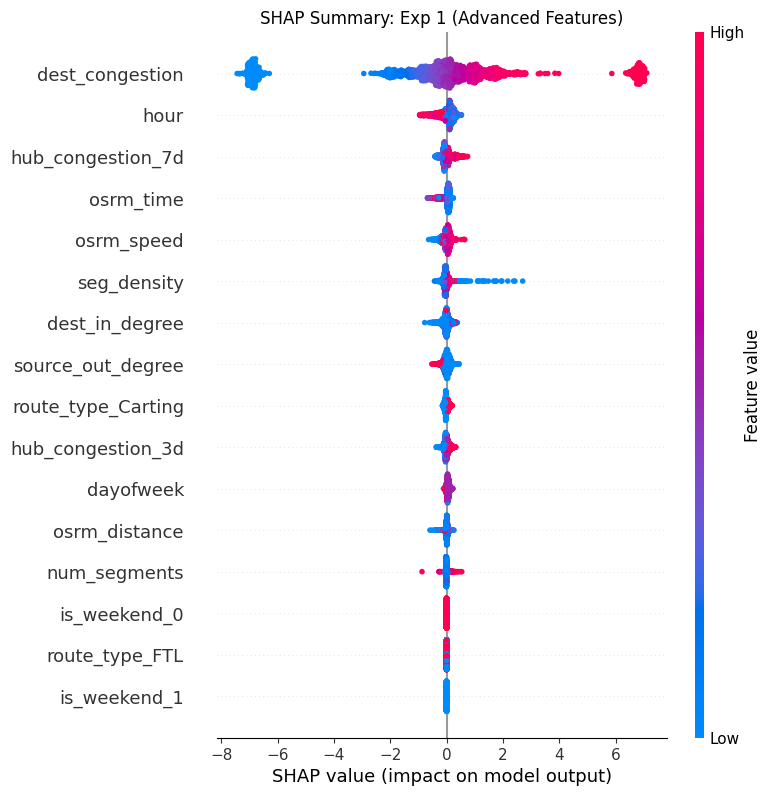

✅ SHAP 图生成成功。
💡 解读指南：
   - 请寻找 'osrm_speed' (预估速度) 和 'dest_congestion' (目的地拥堵)。
   - 如果它们进入 Top 10，说明您构造的人工特征被模型高度认可。


In [13]:
# 📊 [1.1.ipynb 可解释性] Pipeline 特征解构 (修复版)
import shap
import matplotlib.pyplot as plt
import pandas as pd

print("🔍 Phase 4: 人工特征有效性验证")

# 0. 变量名检查与修正
# 确保我们使用的是 Exp 1 训练时定义的测试集变量
if 'X_test_final' in locals():
    target_X_test = X_test_final
elif 'X_test' in locals():
    target_X_test = X_test
else:
    raise NameError("❌ 找不到测试集变量 (X_test_final 或 X_test)。请先运行 Phase 3 的训练代码！")

try:
    # 1. 从 Pipeline 提取特征名
    # 需要处理 OneHotEncoder 产生的特征名变化
    prep = model_pipe.named_steps['preprocessor']
    try:
        cat_names = prep.named_transformers_['cat'].get_feature_names_out(CAT_COLS)
    except:
        # 兼容旧版本 sklearn
        cat_names = prep.named_transformers_['cat'].get_feature_names(CAT_COLS)
    
    feature_names = NUM_COLS + list(cat_names)

    # 2. 转换测试集数据
    # 【关键修复】使用 target_X_test (即 X_test_final)
    print("⏳ 正在转换数据格式...")
    X_test_trans = prep.transform(target_X_test)

    # 3. 计算 SHAP
    print("⏳ 正在计算 SHAP 值 (这可能需要一点时间)...")
    model = model_pipe.named_steps['classifier']
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_trans)

    # 4. 绘图
    plt.figure(figsize=(12, 8))
    # max_display=20 只显示前20个重要特征，避免图表过于拥挤
    shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names, max_display=20, show=False)
    plt.title('SHAP Summary: Exp 1 (Advanced Features)')
    plt.show()

    print("✅ SHAP 图生成成功。")
    print("💡 解读指南：")
    print("   - 请寻找 'osrm_speed' (预估速度) 和 'dest_congestion' (目的地拥堵)。")
    print("   - 如果它们进入 Top 10，说明您构造的人工特征被模型高度认可。")

except Exception as e:
    print(f"⚠️ SHAP 分析发生错误: {e}")
    print("   (通常是因为 Pipeline 未能正确传递特征名，或者数据格式不匹配)")

🔍 Story 2: 人工特征工程有效吗？


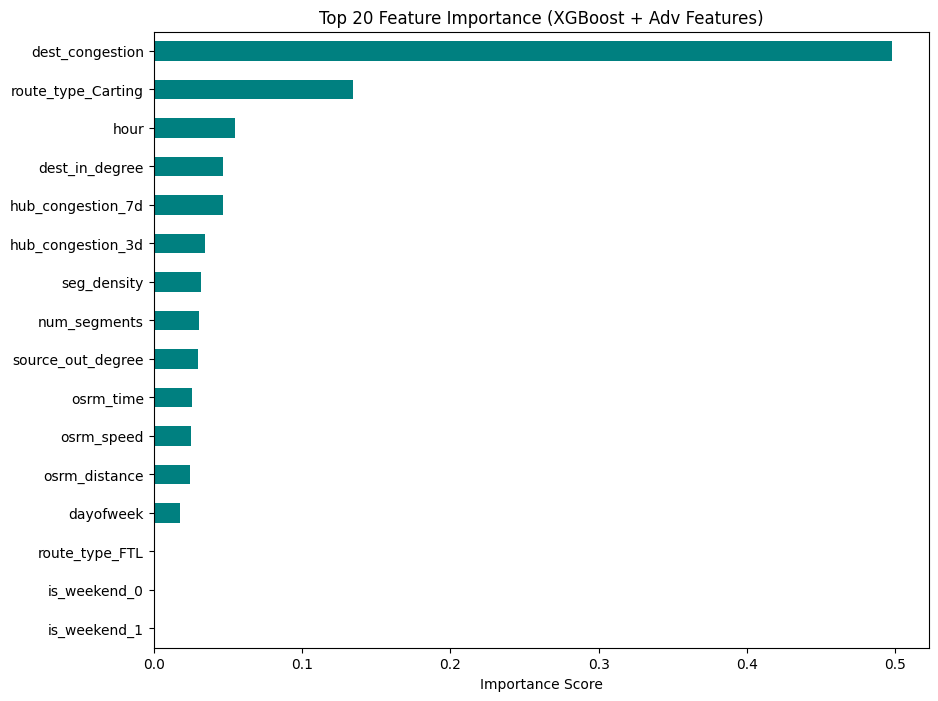

关键特征排名:
 - dest_congestion: Rank 1
 - osrm_speed: Rank 11
 - source_out_degree: Rank 9


In [14]:
# 📊 [1.1.ipynb 分析代码] 特征重要性验证
import pandas as pd
import matplotlib.pyplot as plt

print("🔍 Story 2: 人工特征工程有效吗？")

# 1. 提取特征重要性
# 适配 Pipeline 结构
model = model_pipe.named_steps['classifier']
# 重新获取特征名 (需要处理 OneHot)
prep = model_pipe.named_steps['preprocessor']
try:
    cat_names = prep.named_transformers_['cat'].get_feature_names_out(CAT_COLS)
except:
    cat_names = prep.named_transformers_['cat'].get_feature_names(CAT_COLS)
feat_names = NUM_COLS + list(cat_names)

# 2. 绘图
importances = pd.Series(model.feature_importances_, index=feat_names).sort_values(ascending=False)
top_20 = importances.head(20)

plt.figure(figsize=(10, 8))
top_20.plot(kind='barh', color='teal')
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importance (XGBoost + Adv Features)')
plt.xlabel('Importance Score')
plt.show()

# 3. 检查特定特征
check_list = ['dest_congestion', 'osrm_speed', 'source_out_degree']
print("关键特征排名:")
for f in check_list:
    if f in importances:
        rank = list(importances.index).index(f) + 1
        print(f" - {f}: Rank {rank}")
    else:
        print(f" - {f}: Not found/Pruned")